Training the cost model with a ranking loss

In [1]:
from os import environ
environ['train_device'] = 'cuda:1' # training device: 'cpu' or 'cuda:X'
environ['store_device'] = 'cuda:1' # Data storing device:  'cpu' or 'cuda:X'
environ['dataset_file'] = '/data/scratch/mmerouani/processed_datasets/dataset_batch4X_train_val_set.pkl' #training / validation set
environ['test_dataset_file'] = '/data/scratch/mmerouani/processed_datasets/dataset_batch4X_test_set.pkl' #test set
environ['benchmark_dataset_file']='/data/scratch/mmerouani/processed_datasets/dataset_Benchmark_batch10.pkl' #benchmarks set 
#a copy of these datasets can be found in /data/commit/tiramisu/cost-model_datasets/processed_datasets/

%run utils.py # imports and defines some utils functions

### Data loading

In [2]:
train_val_dataset, val_bl, val_indices, train_bl, train_indices = load_data_meta_batches(dataset_file, 0.2, max_batch_size=832)
test_dataset, test_bl, test_indices, _, _ = load_data_meta_batches(test_dataset_file, 1)

loading batches from: /data/scratch/mmerouani/processed_datasets/dataset_batch4X_train_val_set.pkl


100%|██████████| 46640/46640 [27:29<00:00, 28.27it/s]   


GPU memory on cuda:1 nearly full, switching to CPU memory
Number of meta batches 46640
Data loaded
Sizes: (9328, 37312) batches
loading batches from: /data/scratch/mmerouani/processed_datasets/dataset_batch4X_test_set.pkl


100%|██████████| 8502/8502 [06:00<00:00, 23.55it/s]  


GPU memory on cuda:1 nearly full, switching to CPU memory
Number of meta batches 8502
Data loaded
Sizes: (8502, 0) batches


### Model definition 

In [3]:
input_size = 2534

criterion = ndcgLoss2PP_meta_batches # Using nDCG-Loss-2++

model = None 
model = Model_Recursive_LSTM_v2_ranking(input_size, drops=[0.112, 0.112, 0.112, 0.112])
model.to(train_device)

optimizer = AdamW(model.parameters(),weight_decay=0.375e-2)    
    

### Model training

In [4]:
bl_dict={'train':train_bl, 'val':val_bl}
log_file = 'log_Recursive_LSTM_v2_ranking.txt'

losses, best_model = train_model_meta_batches(model, criterion, optimizer , max_lr=0.002, dataloader=bl_dict, num_epochs=800, 
                                 logFile=log_file, log_every=1)

Epoch 1/800:  train Loss: 11.1857   val Loss: 8.1448   time: 1209.35s   best loss: 8.1448
Epoch 2/800:  train Loss: 8.4159   val Loss: 7.6152   time: 1214.85s   best loss: 7.6152
Epoch 3/800:  train Loss: 7.9054   val Loss: 7.3919   time: 1247.45s   best loss: 7.3919
Epoch 4/800:  train Loss: 7.6130   val Loss: 7.1376   time: 1225.39s   best loss: 7.1376
Epoch 5/800:  train Loss: 7.4745   val Loss: 6.9653   time: 1236.47s   best loss: 6.9653


KeyboardInterrupt: 

### Loading a pre-trained model

In [5]:
model.load_state_dict(torch.load('Recursive_LSTM_v2_ndcgLoss2PP.pkl',map_location=train_device))
model.to(train_device)
print()


### Basic results on the test set


In [6]:
test_df, test_df_rank_scores = get_results_df_meta_batches(test_dataset, test_bl, test_indices, model)

100%|██████████| 8502/8502 [05:28<00:00, 25.91it/s]


In [8]:
test_df

,name,sched_name,prediction,target,real_rank,predicted_rank
0,function436945,function436945_no_schedule,5.212368,1.000000,26.0,16.0
1,function436945,function436945_schedule_0000,9.486356,3.130280,7.0,8.0
2,function436945,function436945_schedule_0001,3.436958,1.043359,25.0,25.0
3,function436945,function436945_schedule_0003,5.027917,1.176245,15.0,17.0
4,function436945,function436945_schedule_0004,1.015811,0.969065,29.0,27.0
...,...,...,...,...,...,...
276012,function437145,function437145_schedule_0008,16.478519,1.423987,2.0,3.0
276013,function437145,function437145_schedule_0010,16.717077,1.420506,3.0,1.0
276014,function437145,function437145_schedule_0011,5.570871,0.564614,21.0,22.0
276015,function437145,function437145_schedule_0017,16.538778,1.592543,1.0,2.0


In [9]:
test_df_rank_scores.describe()

,Spearman_r,nDCG,nDCG_1
count,8502.000000,8502.000000,8502.000000
mean,0.905679,0.985793,0.948152
std,0.097209,0.021263,0.105755
min,-0.368012,0.604358,0.058371
25%,0.882136,0.984054,0.946073
50%,0.936899,0.992794,0.999684
75%,0.966228,0.996789,1.000000
max,0.995968,0.999972,1.000000


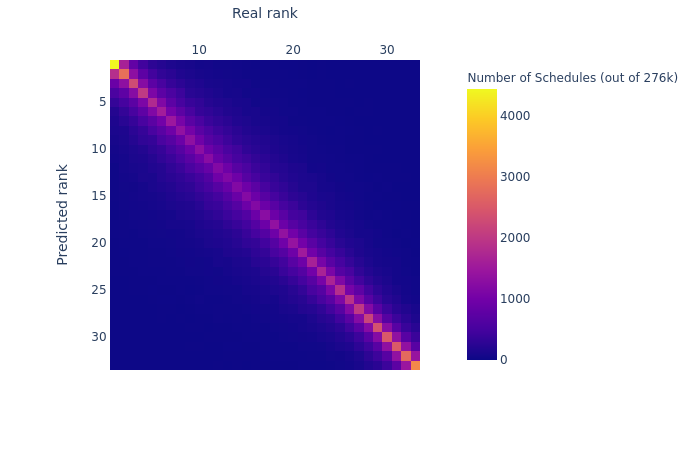

In [12]:
cf_matrix = confusion_matrix(test_df['real_rank'].astype('int32'), test_df['predicted_rank'].astype('int32'))

fig = px.imshow(cf_matrix,
                labels=dict(x="Real rank", y="Predicted rank", color="Number of Schedules (out of 276k)" ),
                x=[str(i) for i in range(1,34)],
                y=[str(i) for i in range(1,34)]
               )
fig.update_xaxes(side="top")
fig.show('png') #use fig.show() for interactive mode

### Basic results on the benchmark set

In [14]:
benchmark_dataset, benchmark_bl, benchmark_indices, _, _ = load_data_meta_batches(benchmark_dataset_file, 1)

loading batches from: /data/scratch/mmerouani/processed_datasets/dataset_Benchmark_batch10.pkl


100%|██████████| 3490/3490 [06:20<00:00,  9.18it/s] 


GPU memory on cuda:1 nearly full, switching to CPU memory
Number of meta batches 3490
Data loaded
Sizes: (3490, 0) batches


In [15]:
benchmark_df, benchmark_df_rank_scores = get_results_df_meta_batches(benchmark_dataset, benchmark_bl, benchmark_indices, model)

100%|██████████| 3435/3435 [03:07<00:00, 18.33it/s]


In [16]:
benchmark_df_rank_scores.describe()

,Spearman_r,nDCG,nDCG_1
count,3435.000000,3435.000000,3435.000000
mean,0.678521,0.935988,0.776508
std,0.413321,0.072894,0.247141
min,-0.976190,0.531952,0.012579
25%,0.666667,0.911556,0.644395
50%,0.810826,0.967105,0.863074
75%,0.910424,0.984400,0.990476
max,1.000000,1.000000,1.000000


In [11]:
pass